In [2]:
from functools import partial
import numpy as onp
import pandas as pd
import networkx as nx
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
%matplotlib inline

import jax.numpy as np
from jax.random import PRNGKey
from jax import jit, grad, lax, random, vmap
from jax.ops import index_update, index, index_add
from jax.nn import one_hot
import numpyro as ny
import numpyro.distributions as dist

In [3]:
@jit
def squareform(edgelist):
    """edgelist to adj. matrix"""
    e = edgelist.shape[0]
    n = ((1 + np.sqrt(1 + 8*e))/2.).astype('int32')
    empty = np.zeros((n,n))
    half = index_add(empty, index[np.triu_indices(n,1)], edgelist)
    full = half+half.T
    return full

In [6]:
def synthesize_network(
    n_nodes,
    *gen_func_args,
    gen_func=partial(nx.connected_watts_strogatz_graph, n_nodes),
):
    n_edges = n_nodes*(n_nodes-1)//2
    g = gen_func(*gen_func_args)
    e = onp.random.beta(2,5,size=(n_edges,))
    p = onp.array(
        squareform(e)*nx.to_numpy_array(g)
    )

    for src,trg in g.edges:
        g.edges[src,trg]['weight'] = p[src,trg]
    return g, p

n_nodes = 30
g, p = synthesize_network(n_nodes, 4, 0.2)

Text(0.5, 1.0, '"True" transmission matrix')

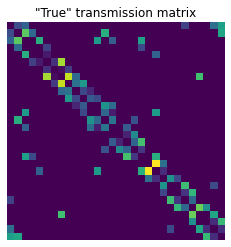

In [7]:
def nodeplot(u):
    plt.figure()
    plt.imshow(u.reshape(-1,1).T)
    plt.axis('off')

def adjplot(p):
    plt.figure()
    plt.imshow(p)
    plt.axis('off')
adjplot(p)
plt.title('"True" transmission matrix')

Text(0.5, 1.0, 'T=2 realize infection')

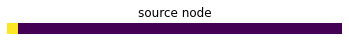

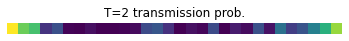

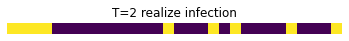

In [14]:

def a_or_b(a,b):
    """probability of a or b is not(not a & not b)"""
    return 1 - onp.multiply(1-a, 1-b)


def spread(p,u,t, T=5):
    """modified https://arxiv.org/pdf/1511.01062.pdf
    """
    # u_add = p@u  # pure heat kernel grows uncontrollably
    # u_p = onp.clip(u + u_add, 0,1)  # clip from paper above
    # u_p = onp.clip(a_or_b(u, u_add), 0,1)  # convolve and clip

    
    u_add = onp.tanh(p@u)   # tanh approx probability of transmission
    u_p = a_or_b(u, u_add)  # probability convolution (w/past)
    
    if t==T:  # end
        return u_p
    else:  # recurse
        return spread(p,u_p, t+1, T)


u = onp.array([1]+(n_nodes-1)*[0])
u_p = spread(p,u,0, T=2)
real = onp.random.binomial(1, u_p)

nodeplot(u)  
plt.title('source node')
nodeplot(u_p)  
plt.title('T=2 transmission prob.')
nodeplot(real)
plt.title('T=2 realize infection')

In [ ]:
n_obs = 50
sources = onp.random.choice(n_nodes, size=(n_obs,1))
init = onp.zeros((n_obs, n_nodes))
onp.put_along_axis(init,sources, 1, 1)

realize = lambda x, T: onp.random.binomial(1, spread(p, x, 0, T))

infections = np.stack([realize(i, 2) for i in init])

late = np.stack([realize(i, 1) for i in infections])

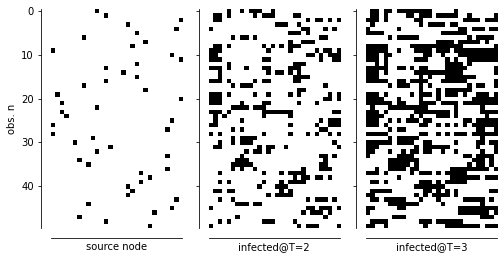

In [13]:
f, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(8,10))
ax[0].spy(init)
ax[0].set_xlabel('source node')
ax[0].set_ylabel('obs. n')
# plt.axis('off')


ax[1].spy(infections)
ax[1].set_xlabel('infected@T=2')



ax[2].spy(late)
ax[2].set_xlabel('infected@T=3')
ax[0].set_xticks([])

sns.despine(f, offset=10)
plt.show()

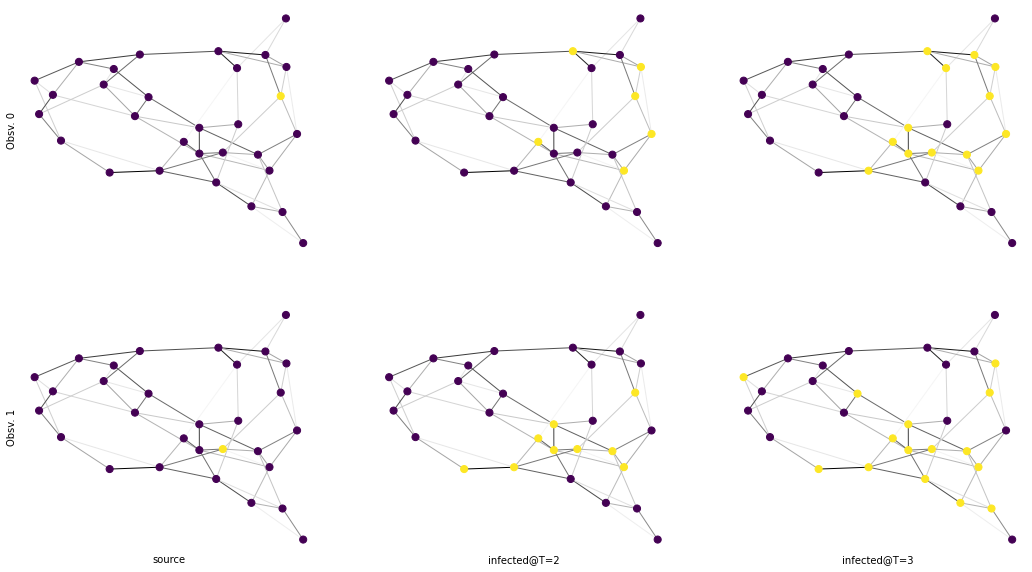

In [15]:
f,ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10), sharex=True, sharey=True)
pos = nx.layout.fruchterman_reingold_layout(g)
weights = [v for k,v in nx.get_edge_attributes(g,'weight').items()]

nx_draw_opts = dict(
    edge_color=weights,
    pos=pos, 
    with_labels=False, 
    node_size=50,
    edge_cmap=cm.binary,
    node_cmap=cm.Paired,
)
for n,axis in enumerate(ax):
#     infected = infect_on_network(a)(x0, T=(n+1)*5)
    nx.draw_networkx(g, node_color=init[n], ax=axis[0],
                    **nx_draw_opts)
    nx.draw_networkx(g, node_color=infections[n], ax=axis[1],
                    **nx_draw_opts)
    nx.draw_networkx(g, node_color=late[n], ax=axis[2],
                    **nx_draw_opts)
    axis[0].set_ylabel(f'Obsv. {n}')

for n,axis in enumerate(ax.flatten()):
    sns.despine(left=True, bottom=True)
ax[1][0].set_xlabel('source')
ax[1][1].set_xlabel('infected@T=2')
ax[1][2].set_xlabel('infected@T=3')
plt.show()

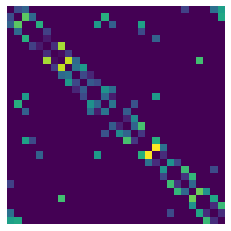

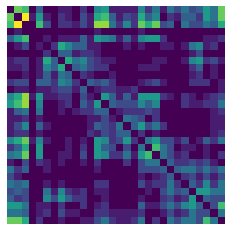

In [16]:
def cosine_sim(X):
    cos = X.T.dot(X)/(onp.sqrt((X**2).sum()))
    return cos - onp.diag(onp.diag(cos))  # valid adjacency

adjplot(p)
adjplot(cosine_sim(infections))


In [17]:
@jit
def diffuse_one_step(p, u):
    u_add = lax.tanh(np.matmul(p,u))  # from neighbors
    u_p = 1-(1-u)*(1-u_add)  # combine with self
    return u_p, u_add

def diffuse(p, T, u_init):
    """
    modified https://arxiv.org/pdf/1511.01062.pdf
    p: transmission probability matrix
    u_init: initial infection node states
    T: num. iterations to observe at
    """
    def scan_fn(u, t):
        return diffuse_one_step(p, u)
    
    u_end, _ = lax.scan(scan_fn, u_init, np.arange(T))
    return u_end

def batched_diffuse(p, T, u_init):
    return vmap(partial(diffuse, p, T))(u_init)

In [18]:
def structure_recovery(infections=None):
    n_cascades, n_nodes  = infections.shape
    n_edges = n_nodes*(n_nodes-1)//2 # complete graph
        
    # node initial infection, relative probability
    ϕ = ny.sample("ϕ", dist.Dirichlet(np.ones(n_nodes)))
    
    # beta hyperpriors
    u = ny.sample("u", dist.Uniform(np.zeros(n_edges), 
                                         np.ones(n_edges)))
    v = ny.sample("v", dist.Gamma(np.ones(n_edges),
                                  rate=20*np.ones(n_edges)))
    Λ = ny.sample("Λ", dist.Beta(u*v, (1-u)*v))
    s_ij = squareform(Λ)  # adjacency matrix to recover via inference
    
    with ny.plate("n_cascades", n_cascades):
        # infer infection source node
        x0 = ny.sample("x0", dist.Categorical(probs=ϕ))
        src = one_hot(x0, n_nodes)
        
        # simulate ode and realize
        p_infectious = batched_diffuse(s_ij, 5, src)
        print(s_ij.shape, x0, src.shape, p_infectious.shape)
#         infectious = spread_jax(s_ij, one_hot(x0, n_nodes),0, 5)
        real = dist.Bernoulli(probs=p_infectious)
        return ny.sample("obs", real, obs=infections)

In [19]:
kernel = ny.infer.NUTS(structure_recovery)
mcmc = ny.infer.MCMC(kernel, num_warmup=1500, num_samples=3000)
mcmc.run(PRNGKey(0), infections=infections)
mcmc.print_summary()
samples = mcmc.get_samples()

(30, 30) [26 25 22  9 14  5 20  4  7  7  0 22 26  7  1  3  7 21  7 11  9  1  5 20
  1  0  3 16  9  2  9  1  8  7 10  7 12 17  1  7 21  1 19 20  1  0  1  1
 11 12] (50, 30) (50, 30)


ValueError: Incompatible shapes for broadcasting: ((1, 50), (50, 30))